## 4. **jpj_4_early_player_classification_modelling**
In this final notebook I proceed as follows:
1. **Creation of player clusters:** Using *sklearn*'s implementation of *k-means*, produced clusters grouping different players. These differnet players where characterised via a Silhouette Coefficient (SC), and together with the cluster mean and St.Dev, the optimal number of clusters was identified

2. **Considered the player morphology within the clusters:**
    - Produced radar charts with the different features at the different angle to help classify the differnt players.
    - Visualisation of the clustering with TSNE
    
3. **Build a Classification model:** Based on the cluster I went ahead and tested a group of potential models, namely (Precision):
    - Support Vector Machine Classifier (SVC) (98.49%)
    - Logistic Regression (LR) (98.72%)
    - k-Nearest Neighbours (KNN) (97.43%)
    - Decision Tree (TR) (89.35%)
    - Random Forest Classifier (RF) (98.97%)
    - Gradient Boost (GB) (99.42%)
    - Ensemble model combining GB, RF, LR, SVC via SoftVoting
    
    To do this I split the dataset into 3 datasets as follows:
        1. 10% = *X,Y_validation* to check inference once modelling is complete
        2. 90% * 80% = *X,Y_train* Training dataset
        3. 90% * 20% = *X,Y_testing* Testing dataset
    
4. **Prediction on a Validation Dataset:** The models above are validated against *X,Y_validation*. The resulting model output precisiont where:

Model | Precision
--- | --- 
Support Vector Machine|98.50%
Logistic Regression|98.96%
k-Nearest Neighbors|97.75%
Decision Tree|90.01%
Random Forest|98.73%
Gradient Boosting|99.25%
Voting Classifier|99.19%


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)


from sklearn import preprocessing, model_selection,metrics, feature_selection, svm
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [3]:
df = pd.read_pickle('./cleanedData/modelling_data.pkl')
df = df.apply(abs) #convert all values to positive
df.drop(['playerid'],inplace=True, axis=1) #drop the unique player id

In [4]:
# Normalising the dataframe to have all columns with a value between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalised = pd.DataFrame(np_scaled)
dt_normalised = df_normalised.as_matrix().astype(np.float)

# Creation of player clusters
I shall first use **sklearn** implementation of *k-means* to produce these clusters. I will then choose the optimal number of clusters based on the Silhouette Coefficient (SC). Quoting the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html):
- The SC is calculated using the mean intra-cluster distance $(a)$ and the mean nearest-cluster distance $(b)$ for each sample. The SC for a sample is $\frac{(b - a)}{max(a, b)}$. To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.
- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Based on the Average Silhoutte & the Intra-Cluster Mean and St.Dev, optimal clusters can then be identified.

In [5]:
# pca = PCA()
# pca.fit(dt)
# pca_samples = pca.transform(dt)

# fig, ax = plt.subplots(figsize=(14, 5))
# sns.set(font_scale=1)
# plt.step(range(dt.shape[1]), pca.explained_variance_ratio_.cumsum(),
#          where='mid',label='cumulative explained variance')
# sns.barplot(np.arange(1,dt.shape[1]+1), pca.explained_variance_ratio_,
#             alpha=0.5, color = 'g',label='individual explained variance')
# plt.xlim(0, 10)
# ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])
# plt.ylabel('Explained variance', fontsize = 14)
# plt.xlabel('Principal components', fontsize = 14)
# plt.legend(loc='best', fontsize = 13);

In [15]:
# perform clustering for a range of possible groupings
score = []
mean = []
std = []
x = list(range(5, 19))
print('Searching for clusters in the range [{},{}]'.format(min(x),max(x)))
print('Number of Clusters - Silhouette Acg')
for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(dt_normalised)
    clusters = kmeans.predict(dt_normalised)
    silhouette_avg = silhouette_score(dt_normalised, clusters)
    print("{} - {}".format(n_clusters,silhouette_avg))
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score.append(silhouette_avg)
    mean.append(rep.mean())
    std.append(rep.std())

Searching for clusters in the range [5,18]
Number of Clusters - Silhouette Acg
5 - 0.19540749516225495
6 - 0.22558912426752215
7 - 0.2173386881093096
8 - 0.22893083440480305
9 - 0.22547204520329686
10 - 0.22466778632434234
11 - 0.22695863746838993
12 - 0.22239792630327865
13 - 0.22029696711715469
14 - 0.21835286616394758
15 - 0.22081830468501035
16 - 0.22835407954546388
17 - 0.21396436192700483
18 - 0.22074516182372114


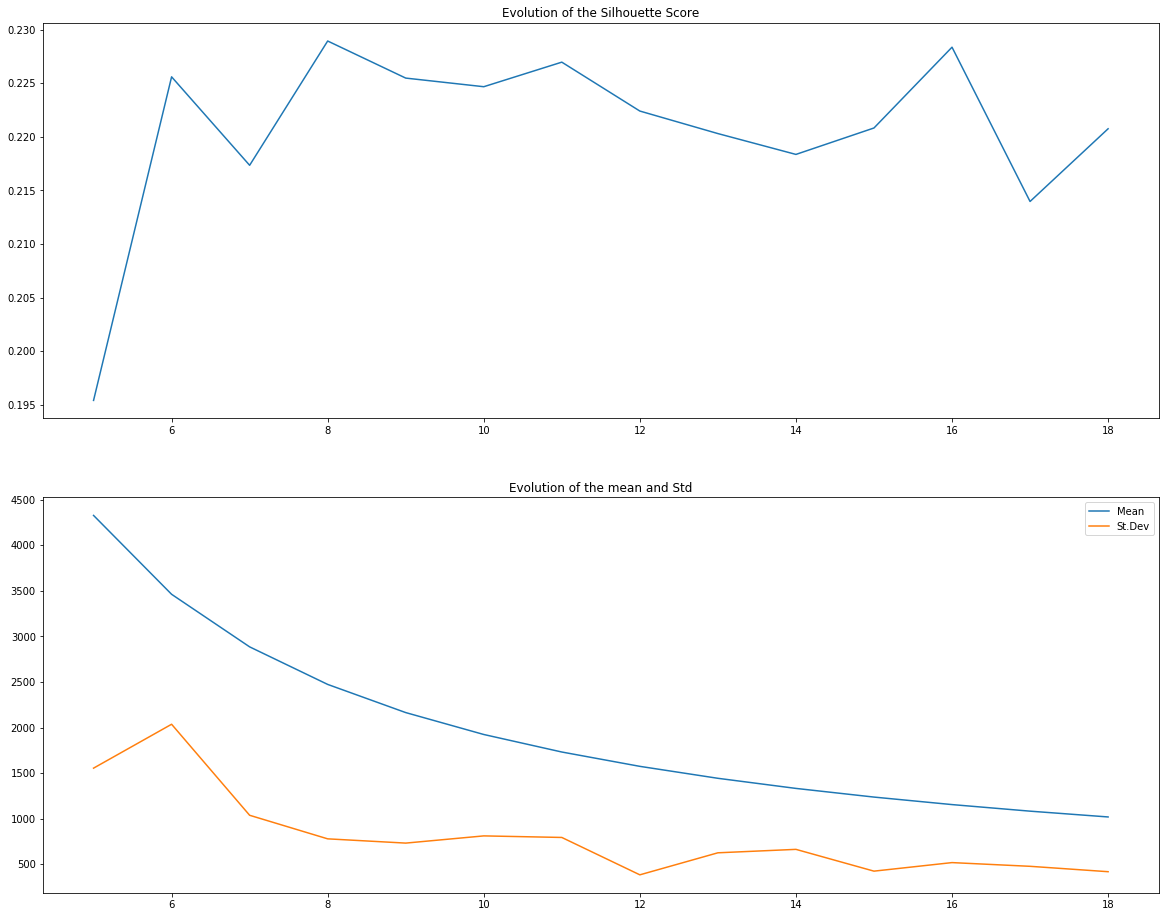

In [16]:
plt.figure(figsize=(20,16))
plt.subplot(2, 1, 1)
plt.plot(x, score, label="score")
plt.title("Evolution of the Silhouette Score")
plt.subplot(2, 1, 2)
plt.plot(x, mean, label="Mean")
plt.plot(x, std, label="St.Dev")
plt.title("Evolution of the mean and Std")
plt.legend()
plt.show()

Considering the above 2 graphs, it has bee decided to go ahead with **8** clusters. Reasons for **8** are:
- First peak of the Silhoutte Avg
- Somewhat the elbow for the Mean and St.Dev

In [26]:
n_clusters = 8

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(dt_normalised)
clusters_players = kmeans.predict(dt_normalised)
silhouette_avg = silhouette_score(dt_normalised, clusters_players)
print('Silhouette Coefficient: {:<.3f}'.format(silhouette_avg))

print('Number of customers in each cluster:')
pd.DataFrame(pd.Series(clusters_players).value_counts(), columns = ['Number of Players']).T


Silhouette Coefficient: 0.230
Number of customers in each cluster:


,3,1,2,7,4,0,5,6
Number of Players,3546,3253,2973,2181,1648,1330,1210,1172


Comments:
 - Clusters 3,1,2 are very well populated. 
 - Clusters 7,4 are good
 - Clusters 0,5,6 are very the lowest. Possibly grouping not soe common outliers

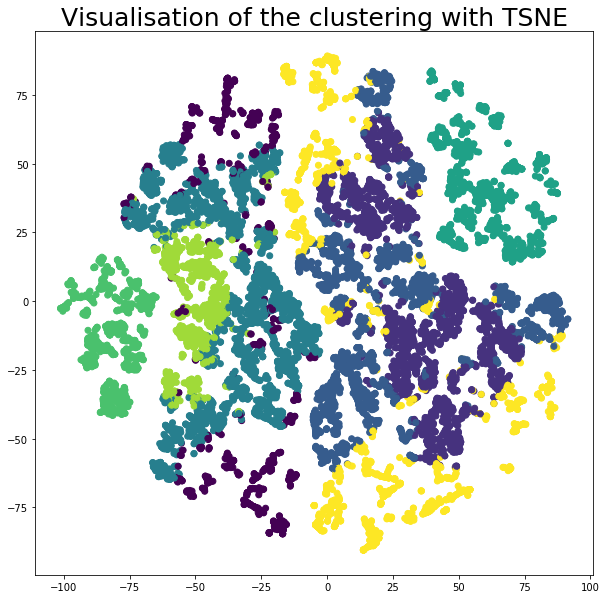

In [96]:
# Visualise the position of the clusters in space with TSNE. 
# “t-Distributed stochastic neighbor embedding (t-SNE) 
# gauge the similarity of objects and then plot the points on a lower dimension
# so that the probability distribution is similar to in the higher plane.

tsne = TSNE(n_components=2)
proj = tsne.fit_transform(dt_normalised)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters_players)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

As expected, the TSNE above illustrates that the clusters have overlaps - which is expected considering a Silhouette Coefficient Avg of 0.23. That said, segregated clusted are clearly visible.

In [28]:
# merging cluster with dataframe
df['cluster'] = clusters_players

#### Player Morphology within the Clusters

In [29]:
clst = []
for cls in range(16):
    res = []
    dt0 = df[df['cluster'] == cls]
    dt0.drop(['cluster'] ,inplace=True, axis=1)
    for col in dt0.columns.tolist():
        res.append( dt0[col].mean() )
    clst.append(res)
    
COLS = []
for col in dt0.columns.tolist():
    COLS.append(col+'_MEAN')
dt1 = pd.DataFrame.from_records(clst, columns=COLS)

In [42]:
# normalise data frame to have columns range from 0 - 1
dt2 = dt1
dt2 = dt2+0.00000001
dt2 -= dt2.min()
dt2 /= dt2.max()

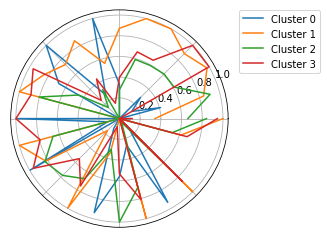

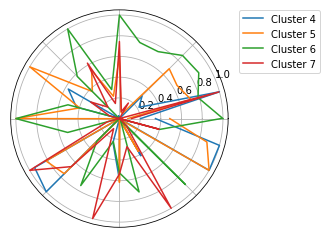

In [78]:
def polPlot(minClust,maxClust):
#     plt.figure(figsize=(5,5))
    ax = plt.subplot(111, projection='polar')
    theta = 2 * np.pi * np.linspace(0, 1, 25)
    for i in range(minClust,maxClust):
        ax.plot(theta, dt2.loc[i], label="Cluster {}".format(i))
    ax.set_xticklabels('')
    ax.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # ax.set_title("Player Clustering ", va='bottom')
    plt.show()

plt.subplot(121)    
polPlot(0,4)
plt.subplot(122)    
polPlot(4,8)

# Build a Classification Model
In this part, I will classify players into the different clusters previously identified. To do this, I will test several classifiers implemented in *scikit*. I define a class that allows to interface several of the functionalities common to these different classifiers and a plotting class:

In [79]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [45]:
# normalise the dataset and have X as features and Y as target
df_normalise = df
df_normalise = df_normalise+0.00000001
df_normalise -= df_normalise.min()
df_normalise /= df_normalise.max()
df_normalise['cluster'] = clusters_players

X = df_normalise.drop(['cluster'],axis=1)
Y = df_normalise['cluster']

# Split the dataset into 3 datasets:
#  - 10% validation to check inference once modelling is complete
#  - 90% -> 80% Training dataset
#        -> 20% Testing dataset
X, X_validation, Y, Y_validation = model_selection.train_test_split(X, Y, train_size = 0.9)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [46]:
# Support Vector Machine Classifier (SVC)
# Select the right hyperplane with the maximum segregation from the either nearest data points

svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 98.49 % 


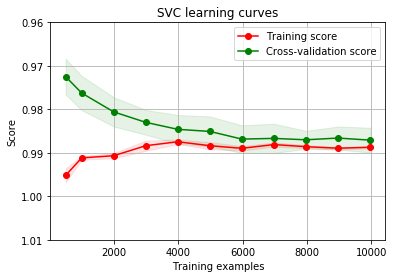

In [81]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.96],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

In [48]:
# Logistic Regression
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 98.72 % 


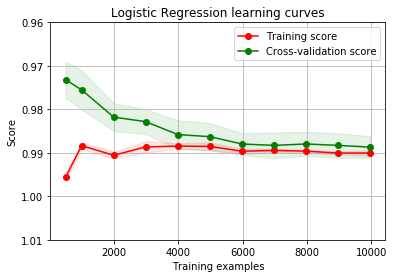

In [82]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.96], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [51]:
# k-Nearest Neighbours
# for each test data point, looking at the K nearest training data points and take the most frequently
# occurring classes and assign that class to the test data. 
# K represents the number of training data points lying in proximity to the test data point which we are 
# going to use to find the class.
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 97.43 % 


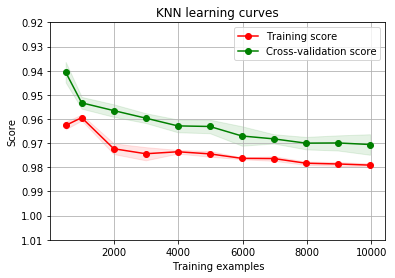

In [85]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNN learning curves", X_train, Y_train,
                        ylim = [1.01, 0.92], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [53]:
# Decision Tree
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 89.35 % 


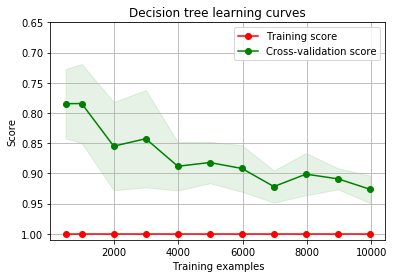

In [87]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.65], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [55]:
#  Random Forest
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)


Precision: 98.97 % 


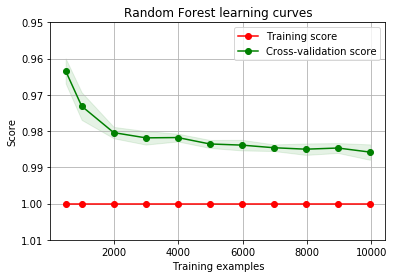

In [88]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.95], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [59]:
# Gradient Boost
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)


Precision: 99.42 % 


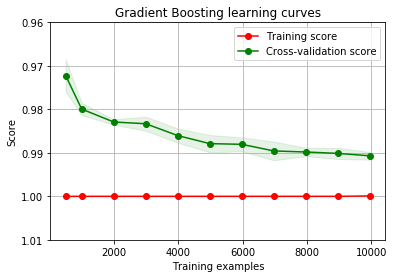

In [91]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.96], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [92]:
# Model ensemble
# Based on all the previous models, I shall combine the optimal paramters identified above for 
# all those models with a Precision > 98.0%
# Namely, GB, RF, LR, SVC
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)

In [63]:
votingC = ensemble.VotingClassifier(estimators=[('gb', gb_best),
                                                ('rf', rf_best),
                                                ('lr', lr_best)
                                                ('svc', svc_best)], voting='soft')    

In [64]:
votingC = votingC.fit(X_train, Y_train)

In [65]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 99.36 % 


# Testing the Predictions on the Validation Dataset

In [94]:
classifiers = [(svc, 'Support Vector Machine'),
               (lr, 'Logistic Regression'),
               (knn, 'k-Nearest Neighbors'),
               (tr, 'Decision Tree'),
               (rf, 'Random Forest'),
               (gb, 'Gradient Boosting')]
for clf, label in classifiers:
    print('\n{}'.format(label))
    clf.grid_predict(X_validation, Y_validation)
print('')
print('Voting Classifier')
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_validation, votingC.predict(X_validation))))


Support Vector Machine
Precision: 98.50 % 

Logistic Regression
Precision: 98.96 % 

k-Nearest Neighbors
Precision: 97.75 % 

Decision Tree
Precision: 90.01 % 

Random Forest
Precision: 98.73 % 

Gradient Boosting
Precision: 99.25 % 

Voting Classifier
Precision: 99.19 % 


# Conclusion
GB and Ensemble model had the highest precisions within the classification. Possible explanation could be that GB is already really good model and the addition of the other less precise models results in a degraded model.

# Further Work
- Revisit the feature creation and add additional dimensions to help classify the players. For example:
    - Country GDP - to identify player deposable income  
    - Player prefence to new games - does he get bored and whats new games?
    - %% of games played on high stakes machines - what is his risk appettite?
    - Big Win Stickness - Is she/he a "Go Big or Go Home?" type player
    - *Sex - I mistakenly excluded this in the modelling*
- Spend a bit more time on the clustering to gain a more indepth understanding of the Customer Profiles
- Modelling: I am quite happy with the results given the high precision, yet I would have a look at Confusion Matrices per model to better gauge the accuracies
